In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# 1. Lakukan EDA dan Pre-Processing sesuai dengan tujuan analisis dan kondisi data!

In [3]:
# load dataset diabetes
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# cek missing value
data.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


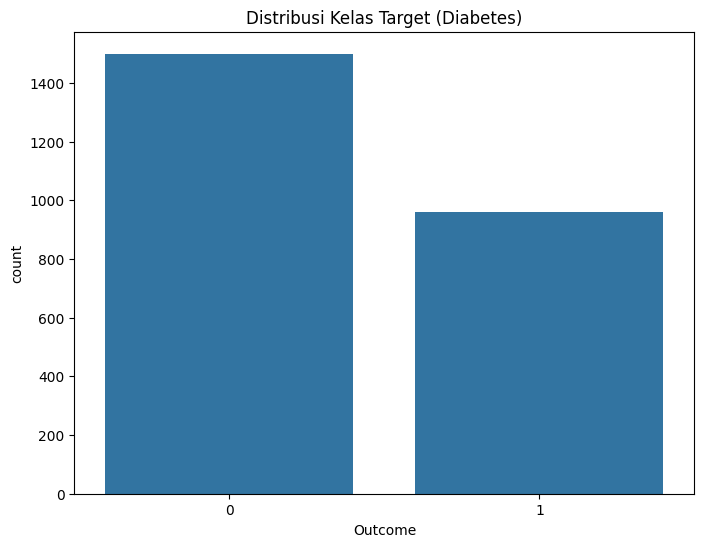

In [8]:

plt.figure(figsize=(8,6))
sns.countplot(data=data, x='Outcome')
plt.title('Distribusi Kelas Target (Diabetes)')
plt.show()


variabel Outcome menunjukkan distribusi dua kelas yang tidak seimbang. maka akan dilakukan oversampling menggunakan SMOTE

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Memisahkan fitur dan label
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversampling menggunakan SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standarisasi fitur
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)


Distribusi Kelas Setelah SMOTE: Counter({1: 1195, 0: 1195})


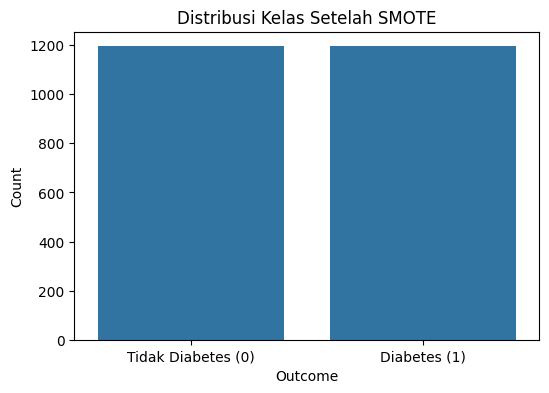

In [ ]:
from collections import Counter

class_distribution_after_smote = Counter(y_train_resampled)

print("Distribusi Kelas Setelah SMOTE:", class_distribution_after_smote)

distribution_df = pd.DataFrame(class_distribution_after_smote.items(), columns=['Outcome', 'Count'])

# Visualisasi distribusi kelas setelah SMOTE
plt.figure(figsize=(6, 4))
sns.barplot(x='Outcome', y='Count', data=distribution_df)
plt.title("Distribusi Kelas Setelah SMOTE")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.xticks([0, 1], labels=['Tidak Diabetes (0)', 'Diabetes (1)'])
plt.show()


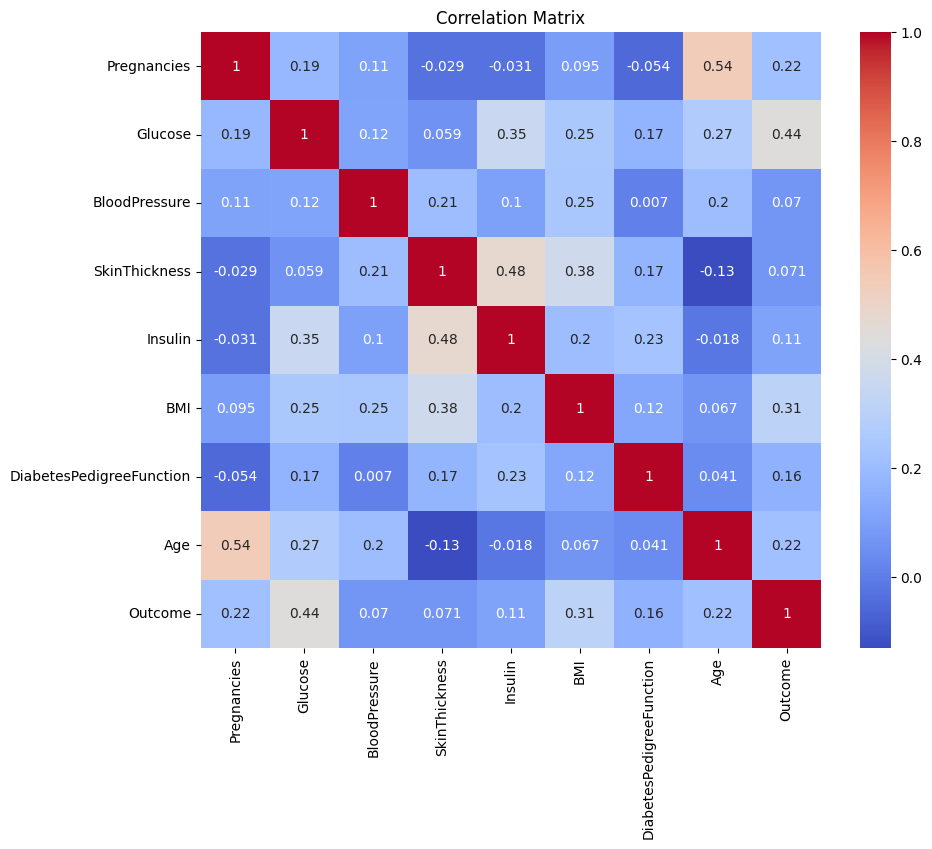

In [22]:
# heatmap untuk melihat korelasi
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

visualisasi heatmap diatas bertujuan untuk mengetahui korelasi atau hubungan antar variabel dalam dataset diabetes. Contohnya Glucose memiliki korelasi tertinggi dengan Outcome (0.44), menunjukkan bahwa kadar glukosa berhubungan signifikan dengan diabetes. BMI (0.31) dan Age (0.22) juga memiliki korelasi positif dengan Outcome, yang berarti individu dengan BMI lebih tinggi dan usia lebih tua cenderung memiliki risiko lebih tinggi.

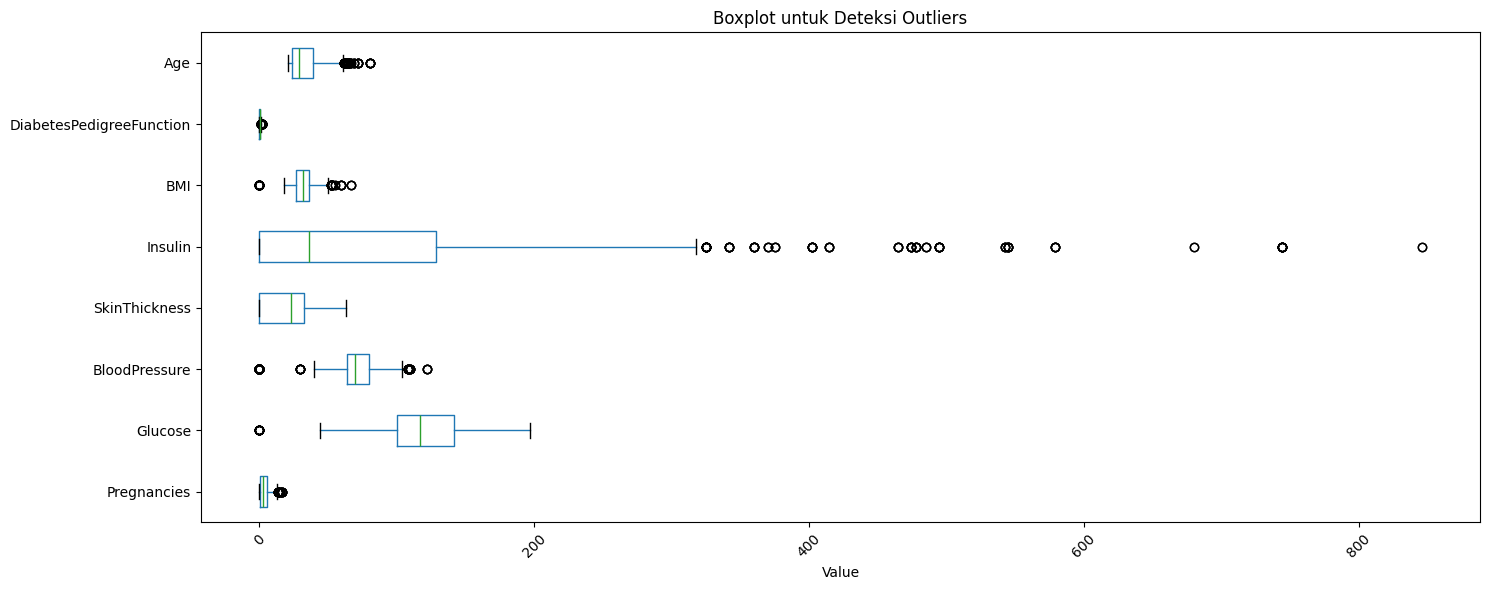

In [30]:
# cek outliers
plt.figure(figsize=(15, 6))
data.drop('Outcome', axis=1).boxplot(grid=False, vert=False)
plt.title('Boxplot untuk Deteksi Outliers')
plt.xlabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
#remove outliers
def remove_outliers_iqr(df):
    for column in df.columns:
        if data[column].dtype != 'object':
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df_no_outliers = remove_outliers_iqr(data.drop('Outcome', axis=1))
print(f"Jumlah data setelah menghilangkan outliers: {len(df_no_outliers)}")

Jumlah data setelah menghilangkan outliers: 2025


karena terdapat banyak outliers yang dimana berpotensi mempengaruhi model seperti KNN maka dilakukan remove outliers dengan metode IQR

In [33]:
# memisahkan fitur dan target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [34]:
#standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
# Membagi data : 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. Lakukan pemodelan menggunakan algoritma klasifikasi KNN, Decision Tree dan Naive Bayes

In [50]:
# model evaluasi
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)

    print(f"\nEvaluasi Model {model_name}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"Precision : {prec:.4f}")

    print("\nConfusion Matrix :")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return acc, rec, prec

mengevaluasi kinerja model klasifikasi dengan menggunakan metrik Accuracy, Recall, dan Precision. Fungsi ini pertama-tama menghitung nilai akurasi (seberapa sering model membuat prediksi yang benar), recall (kemampuan model mendeteksi kelas positif secara benar), dan precision (seberapa akurat prediksi kelas positif) dan menampilkan confusion matrix dalam bentuk heatmap.

## Klasifikasi Model KNN


Evaluasi Model KNN
Accuracy  : 0.9350
Recall    : 0.9144
Precision : 0.9144

Confusion Matrix :


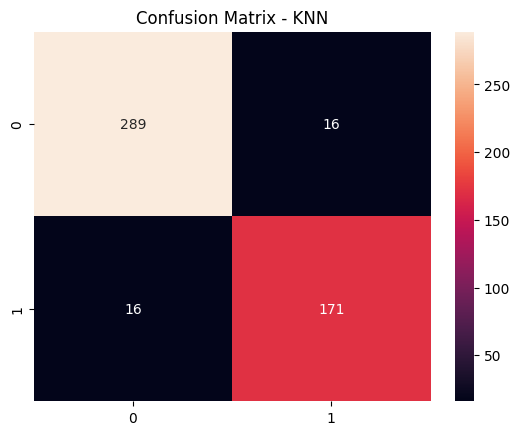

In [51]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
metrics_knn = evaluate_model(y_test, y_pred_knn, "KNN")

## Klasifikasi Model Decision Tree


Evaluasi Model Decision Tree
Accuracy  : 0.9980
Recall    : 0.9947
Precision : 1.0000

Confusion Matrix :


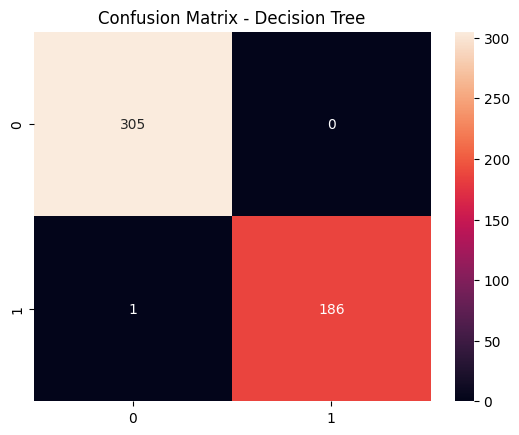

In [38]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
metrics_dt = evaluate_model(y_test, y_pred_dt, "Decision Tree")

## Klasifikasi Model Naive Bayes


Evaluasi Model Naive Bayes
Accuracy  : 0.7175
Recall    : 0.5775
Precision : 0.6429

Confusion Matrix :


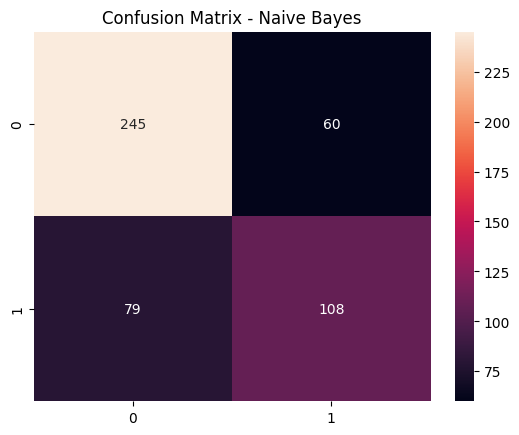

In [46]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
metrics_nb = evaluate_model(y_test, y_pred_nb, "Naive Bayes")

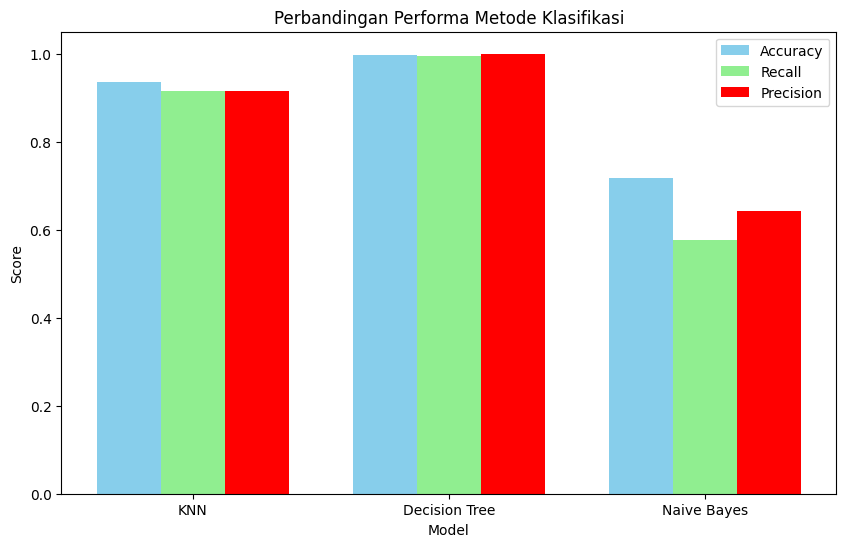

In [55]:
models = ['KNN', 'Decision Tree', 'Naive Bayes']
metrics = np.array([metrics_knn, metrics_dt, metrics_nb])

plt.figure(figsize=(10,6))
x = np.arange(len(models))
width = 0.25

plt.bar(x - width, metrics[:, 0], width, label='Accuracy', color='skyblue')
plt.bar(x, metrics[:, 1], width, label='Recall', color='lightgreen')
plt.bar(x + width, metrics[:, 2], width, label='Precision', color='red')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Perbandingan Performa Metode Klasifikasi')
plt.xticks(x, models)
plt.legend()
plt.show()

Berdasarkan hasil evaluasi, **Decision Tree** adalah model yang terbaik untuk dataset ini karena memiliki akurasi, recall, dan precision yang hampir sempurna, menunjukkan kemampuannya yang sangat baik dalam memprediksi kasus diabetes dengan sedikit kesalahan. **KNN** (K-Nearest Neighbors) memiliki performa yang cukup baik, tetapi sedikit lebih rendah karena sensitif terhadap outliers dan jarak antar data, yang dapat memengaruhi akurasinya. Di sisi lain, **Naive Bayes** menunjukkan kinerja yang paling rendah karena mengasumsikan independensi antar fitur, yang tidak selalu terjadi pada dataset ini, sehingga gagal menangkap hubungan yang lebih kompleks antara variabel. Perbedaan utama antara ketiga model ini adalah bahwa **Decision Tree** mampu menangani data yang lebih kompleks dengan mempartisi data secara hierarkis, **KNN** bergantung pada kedekatan data dalam ruang fitur, dan **Naive Bayes** bekerja dengan probabilitas yang lebih sederhana, yang kurang efektif jika fitur tidak benar-benar independen.